# Image classification of mask wearing state

이 파일은 boostcamp AI Tech에서 제공하는 sample_submission.ipynb과 이민준 캠퍼님의 resnet18 base code를 참고하여 작성헸습니다.

### 0. Libarary 불러오기 및 경로설정

In [1]:
import os
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A

import torchvision
from torchvision import transforms, utils
from torchvision.transforms import Resize, ToTensor, Normalize, RandomHorizontalFlip
from baseline.dataset import AddGaussianNoise

In [2]:
# 훈련 데이터셋 폴더 경로 지정
train_dir = '/opt/ml/input/data/train'
train_img_dir_path = os.path.join(train_dir, 'images')
train_img_dir_path

'/opt/ml/input/data/train/images'

In [3]:
# 테스트 데이터셋 폴더 경로를 지정해주세요.
test_dir = '/opt/ml/input/data/eval'

In [4]:
train_df = pd.read_csv('./input/data/train/train.csv')
train_df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


### 1. Dataset 정의

In [5]:
# dir_name 디렉토리 하부에 있는 모든 파일을 검색합니다. 
def search(dir_name, result):
    try:
        filenames = os.listdir(dir_name)
        for fname in filenames:
            if fname[0] == '.' : # .으로 시작하는 파일명을 제외함 (ex: ._00~~~ 파일 제외)
                continue
            filename = os.path.join(dir_name, fname) # 폴더명, 파일명 
            if os.path.isdir(filename): # 디렉토리 여부 확인
                search(filename, result) # 하부 파일 목록 추출 (incorrect, mask, normal)
            else:
                ext = os.path.splitext(filename)[-1] # splitext()[-1] : 확장자 찾기 
                if ext:
                    result.append(filename) # 확장자 추가
                # if ext != '.jpg':
                #     print(ext)
    except PermissionError: 
        print("파일의 경로 설정을 확인해보세요.")
        pass

In [6]:
all_path = []
search(train_img_dir_path, all_path)

In [7]:
all_path = sorted(all_path) # 파일을 sorting 해줍니다. 

len(all_path)

18900

isdir과 listdir로 검색한 파일은 총 18900 개입니다.

2700 개의 image 폴더는 각각 7개의 파일(normal, incorrect, mask1~5)로 구성되어있습니다.

In [8]:
all_path[:10]

['/opt/ml/input/data/train/images/000001_female_Asian_45/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask1.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask2.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask3.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask4.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/mask5.jpg',
 '/opt/ml/input/data/train/images/000001_female_Asian_45/normal.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/incorrect_mask.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/mask1.jpg',
 '/opt/ml/input/data/train/images/000002_female_Asian_52/mask2.jpg']

In [9]:
# 파일 확장자 확인
exts = []
for filepath in all_path:
    ext = os.path.splitext(filepath)[-1]
    if ext not in exts:
        exts.append(ext)
print(exts)

['.jpg', '.png', '.jpeg']


파일명을 분석하여 조건에 따라 class label list(정답)을 생성합니다.

- class 0 : wear, male, age < 30
- class 1 : wear, male, 30 <= age < 60
- class 2 : wear, male, 60 <= age
- class 4 : wear, female, age < 30
- class 5 : wear, female, 30 <= age < 60
- class 6 : incorrect, female, 60 <= age
- class 7 : incorrect, male, age < 30
- class 8 : incorrect, male, 30 <= age < 60
- class 9 : incorrect, male, 60 <= age
- class 10 : incorrect, female, age < 30
- class 11 : incorrect, female, 30 <= age < 60
- class 12 : not wear, female, 60 <= age
- class 13 : not wear, male, age < 30
- class 14 : not wear, male, 30 <= age < 60
- class 15 : not wear, male, 60 <= age
- class 16 : not wear, female, age < 30
- class 17 : not wear, female, 30 <= age < 60
- class 18 : not wear, female, 60 <= age

In [10]:
# labeling : 조건에 따라 label에 숫자를 더해줍니다.
def labeling(name):
    label = 0
    info, mask_type = name.split('/')[-2:] # info = 'image 폴더명', mask_type = '파일명'
    info = info.split('_') # info = [index, gender, race, age]
    gender, age = info[1], int(info[3])
    if 'incorrect' in mask_type:
        label += 6
    elif 'normal' in mask_type:
        label += 12

    if gender == 'female':
        label += 3
    
    if 30 <= age < 60:
        label += 1
    elif age >= 60:
        label += 2
        
    return label

In [11]:
train_path_label = pd.DataFrame(all_path, columns = ['path'])

train_path_label['label'] = train_path_label['path'].map(lambda x : labeling(x))
train_path_label

,path,label
0,/opt/ml/input/data/train/images/000001_female_...,10
1,/opt/ml/input/data/train/images/000001_female_...,4
2,/opt/ml/input/data/train/images/000001_female_...,4
3,/opt/ml/input/data/train/images/000001_female_...,4
4,/opt/ml/input/data/train/images/000001_female_...,4
...,...,...
18895,/opt/ml/input/data/train/images/006959_male_As...,0
18896,/opt/ml/input/data/train/images/006959_male_As...,0
18897,/opt/ml/input/data/train/images/006959_male_As...,0
18898,/opt/ml/input/data/train/images/006959_male_As...,0


y에서는 데이터셋을 좀 더 쉽게 쉽게 다룰 수 있도록 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 

이 torch.utils.data.Dataset을 상속받아 직접 Custom DataSet을 만들어서 사용하는 경우도 많습니다. 

(reference : https://wikidocs.net/57165)

In [12]:
# dataset을 상속받아 만든 CustomDataset 입니다. 
class CustomDataset(Dataset):
    def __init__(self, img_paths_label, transform):
        self.X = img_paths_label['path']
        self.y = img_paths_label['label']
        self.transform = transform
    def __getitem__(self, index):
        image = Image.open(self.X.iloc[index])
        label = self.y.iloc[index]

        if self.transform:
            image = self.transform(image) # torchvision 사용시
            #image = self.transform(image=np.array(image))["image"] # albumentations 사용시

        return image, torch.tensor(label)

    def __len__(self):
        return len(self.X)

In [13]:
# torchvision에서 제공해주는 다양한 함수를 이용하여 입력 영상을 전처리합니다.
# [512, 384] 크기로 영상을 resize하고 데이터를 Tensor로 만들어줍니다.
# 이후 정규화를 해줍니다. ([0,255]->[0, 1]로 표현합니다.  )

train_transform  = transforms.Compose([
    #CenterCrop((320, 256)),
    Resize((512, 384), Image.BILINEAR),
    RandomHorizontalFlip(p=0.3), # randomly H_flip images
    #ColorJitter(brightness=0.1), # randomly change color space
    #RandomPerspective(distortion_scale=0.3, p=0.2),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
    #AddGaussianNoise(),
])

In [ ]:
# train_transform = A.Compose(
#     [
#         A.CenterCrop(height=320, width=256, p=1.0),
#         A.Resize(512, 384),
#         A.HorizontalFlip(p=0.3),
#         A.CoarseDropout(p=0.3),
#         A.RandomBrightnessContrast(brightness_limit=(-0.3, 0.3), contrast_limit=(-0.3, 0.3), p=0.3),    
#         A.OneOf(
#             [
#                 A.GridDistortion(p=0.2),
#                 A.OpticalDistortion(p=0.2),
#             ],
#             p=1,
#         ),
#         A.OneOf(
#             [
#                 A.ChannelShuffle(p=0.2),  
#                 A.GaussNoise(var_limit=(1000, 1600), p=0.2),
#                 A.GaussianBlur(p=0.2),
#                 A.GlassBlur(p=0.2),
#                 A.MedianBlur(p=0.2),
#                 A.MotionBlur(p=0.2),  
#                 A.RGBShift(p=0.2),
#             ],
#             p=1,
#         ),       
#         A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2]),
#         ToTensorV2(p=1.0),
#     ]
# )

In [14]:
valid_transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])

In [ ]:
# valid_transform = A.Compose(
#     [
#         A.Resize(512, 384),
#         A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.2, 0.2, 0.2]),
#         ToTensorV2(p=1.0),
#     ]
# )

train data와 validation data를 구분합니다.

label의 비율을 유지하면서 분할합니다.

train data : 15120 (80%)

validation data : 3780 (20%)

In [15]:
from sklearn.model_selection import train_test_split
train, valid = train_test_split(train_path_label, test_size = 0.2, 
                                shuffle = True, stratify = train_path_label['label'],
                                random_state = 34 )

print("The number of train dataset :", len(train))
print("The number of valid dataset :", len(valid))

The number of train dataset : 15120
The number of valid dataset : 3780


In [16]:
# Batch size 는 64로 설정하고, shuffle을 하여 DataLoader를 정의했습니다.
BATCH_SIZE = 64

train_dataset = CustomDataset(train, train_transform)

train_dataloader = DataLoader(train_dataset, 
                            batch_size=BATCH_SIZE,
                            shuffle=True
                            )

In [17]:
valid_dataset = CustomDataset(valid, valid_transform)

valid_dataloader = DataLoader(valid_dataset,
                            batch_size = BATCH_SIZE,
                            shuffle = True
                            )

In [18]:
# dataloader는 [batchsize, channel, height, wide] 를 출력합니다. 
next(iter(train_dataloader))[0].shape

torch.Size([64, 3, 512, 384])

### 2. Model 정의

In [19]:
# !pip instasll --upgrade jupyter ipywidgets
model = torchvision.models.resnet34(pretrained = True)

In [20]:
import math

OUTPUT_CLASS_NUM = 18
model.fc = torch.nn.Linear(in_features = 512, out_features = OUTPUT_CLASS_NUM, bias = True) 

# xavier uniform : 이전 노드와 다음 노드의 개수에 의존하는 초기화 방법으로 uniform/normal initialization의 두 가지 유형이 있습니다.
torch.nn.init.xavier_uniform_(model.fc.weight)
stdv = 1. / math.sqrt(model.fc.weight.size(1))
model.fc.bias.data.uniform_(-stdv, stdv)

model.fc.weight.shape[0]

18

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
device

device(type='cuda', index=0)

### Weights in weighted loss

[ref] https://discuss.pytorch.org/t/weights-in-weighted-loss-nn-crossentropyloss/69514/2

In [22]:
# Cross Entropy Loss Weight를 적용합니다.
# Class에 해당하는 데이터 비율에 반비례하도록 weight 설정합니다.

loss_weight = torch.zeros(OUTPUT_CLASS_NUM, dtype = torch.float32).to(device)

for i in range(OUTPUT_CLASS_NUM):
    loss_weight[i] = len(train_path_label[train_path_label['label']==i])

loss_weight = loss_weight / loss_weight.sum()
loss_weight = (1-loss_weight)
print('loss weight :', loss_weight)

loss weight : tensor([0.8534, 0.8921, 0.9775, 0.8077, 0.7836, 0.9714, 0.9707, 0.9784, 0.9955,
        0.9615, 0.9567, 0.9943, 0.9707, 0.9784, 0.9955, 0.9615, 0.9567, 0.9943],
       device='cuda:0')


In [23]:
model.to(device)

LEARNING_RATE = 0.0001 # 학습에서 사용하는 optimizer의 학습률 옵션 설정
NUM_EPOCH = 20 # 학습에서 데이터셋을 얼마나 많이 학습할 지 반복 횟수를 결정하는 옵션

loss_fn = torch.nn.CrossEntropyLoss(weight = loss_weight) # 분류 학습에서 많이 사용하는 Cross Entropy loss를 objective function 적용
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) # weight updqte를 위한 optimizer를 Adam으로 설정

dataloaders = {
    "train" : train_dataloader,
    "test" : valid_dataloader
}

### 3. Inference

In [24]:
best_test_accuracy = 0.
best_test_loss = 9999.

for epoch in tqdm(range(NUM_EPOCH)):
    # train_dataset = CustomDataset(train, train_transform)

    # train_dataloader = DataLoader(train_dataset, 
    #                             batch_size=BATCH_SIZE,
    #                             shuffle=True
    #                             )
    for phase in ["train", "test"]:
        running_loss = 0.
        running_acc = 0.
        if phase == "train":
            model.train() # 네트워크 모델을 train 모드로 두어 gradient를 계산하고 여러 sub module (배치 정규화, 드롭아웃 등 )이 train mode로 작동할 수 있도록 함
        elif phase == "test":
            model.eval() # 네트워크 모델을 eval 모드로 부여하여 여러 sub module들이 eval mode로 작동할 수 있도록 설정 

        for ind, (images, labels) in enumerate(dataloaders[phase]):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad() # parameter gradient를 업데이트 전 초기화 함

            with torch.set_grad_enabled(phase == "train"): # train 모드일 시에는 gradient 를 계산하고, 
                                                           # 아닌 경우에는 gradient를 계산하지 않아 연산량이 최소화
                logits = model(images)
                _, preds = torch.max(logits, 1) # 모델에서 linear 값으로 나오는 예측 값을 최대 output index를 찾아 label([2])로 변경함
                loss = loss_fn(logits, labels)

                if phase == "train":
                    loss.backward() # 모델의 예측 값과 실제 값의 CrossEntropy 차이를 통해 gradient 계산
                    optimizer.step() # 계산된 gradient 를 가지고 모델 업데이트

            running_loss += loss.item() * images.size(0) # 한 Batch에서의 loss 값 저장
            running_acc += torch.sum(preds == labels.data) # 한 Batch에서의 Accuracy 값 저장
            
        # 한 EPOCH이 모두 종료되었을 때
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_acc / len(dataloaders[phase].dataset)

        print(f"현재 epoch-{epoch}의 {phase}-데이터 셋에서 평균 Loss : {epoch_loss: .3f}, 평균 Accuracy : {epoch_acc: .3f}")
        if phase == "test" and best_test_accuracy < epoch_acc: # phase가 test일 때, best accuracy 계산
            best_test_accuracy = epoch_acc
        if phase == "test" and best_test_loss > epoch_loss : # phase가 test일 때 test loss 계산
            best_test_loss = epoch_loss
print("학습 종료!")
print(f"최고 accuracy : {best_test_accuracy}, 최고 낮은 loss: {best_test_loss}")

현재 epoch-0의 train-데이터 셋에서 평균 Loss :  0.383, 평균 Accuracy :  0.886
현재 epoch-0의 test-데이터 셋에서 평균 Loss :  0.138, 평균 Accuracy :  0.957
현재 epoch-1의 train-데이터 셋에서 평균 Loss :  0.047, 평균 Accuracy :  0.987
현재 epoch-1의 test-데이터 셋에서 평균 Loss :  0.080, 평균 Accuracy :  0.974
현재 epoch-2의 train-데이터 셋에서 평균 Loss :  0.019, 평균 Accuracy :  0.996
현재 epoch-2의 test-데이터 셋에서 평균 Loss :  0.069, 평균 Accuracy :  0.978
현재 epoch-3의 train-데이터 셋에서 평균 Loss :  0.023, 평균 Accuracy :  0.994
현재 epoch-3의 test-데이터 셋에서 평균 Loss :  0.081, 평균 Accuracy :  0.979
현재 epoch-4의 train-데이터 셋에서 평균 Loss :  0.031, 평균 Accuracy :  0.991
현재 epoch-4의 test-데이터 셋에서 평균 Loss :  0.046, 평균 Accuracy :  0.987
현재 epoch-5의 train-데이터 셋에서 평균 Loss :  0.010, 평균 Accuracy :  0.998
현재 epoch-5의 test-데이터 셋에서 평균 Loss :  0.033, 평균 Accuracy :  0.991
현재 epoch-6의 train-데이터 셋에서 평균 Loss :  0.017, 평균 Accuracy :  0.995
현재 epoch-6의 test-데이터 셋에서 평균 Loss :  0.046, 평균 Accuracy :  0.986
현재 epoch-7의 train-데이터 셋에서 평균 Loss :  0.017, 평균 Accuracy :  0.995
현재 epoch-7의 test-데이터 셋에서 평균 Loss

### 4. Evaluation

In [25]:
def func_eval(model, data_iter, device):
    with torch.no_grad():
        n_total, n_correct = 0, 0
        model.eval()
        for batch_in, batch_out in data_iter :
            y_trgt = batch_out.to(device)
            model_pred = model.forward(batch_in.to(device))
            _, y_pred = torch.max(model_pred, 1) # 행으로 비교
            n_correct += (y_pred == y_trgt).sum().item()
            n_total += batch_in.size(0)
        val_accr = (n_correct / n_total)
    return val_accr

In [26]:
func_eval(model, valid_dataloader, device)

0.9962962962962963

In [27]:
def check_eval(raw_data, dataloader, model, device):
    result = []
    with torch.no_grad():
        model.eval()
        for i, (X,y) in enumerate(dataloader):
            model_pred = model.forward(X.to(device))
            _, y_pred = torch.max(model_pred,1)

            result.append([valid.iloc[i]['path'], y_pred.cpu().numpy()[0], y.cpu().numpy()[0]])
    result = pd.DataFrame(result, columns=['path', 'pred', 'target'])
    return result

In [28]:
valid_testing_dataloader = DataLoader(valid_dataset, shuffle = False)

check_eval_df = check_eval(valid, valid_testing_dataloader, model, device)
check_eval_df

,path,pred,target
0,/opt/ml/input/data/train/images/003049_female_...,3,3
1,/opt/ml/input/data/train/images/001128_female_...,3,3
2,/opt/ml/input/data/train/images/003653_male_As...,7,7
3,/opt/ml/input/data/train/images/003121_female_...,3,3
4,/opt/ml/input/data/train/images/005251_male_As...,12,12
...,...,...,...
3775,/opt/ml/input/data/train/images/001809_male_As...,0,0
3776,/opt/ml/input/data/train/images/005415_female_...,10,10
3777,/opt/ml/input/data/train/images/003794_female_...,4,4
3778,/opt/ml/input/data/train/images/001024-1_femal...,3,3


In [29]:
wrong_df = check_eval_df[check_eval_df['pred'] != check_eval_df['target']]
wrong_df = wrong_df.reset_index(drop = True)
wrong_df

,path,pred,target
0,/opt/ml/input/data/train/images/001335_male_As...,12,13
1,/opt/ml/input/data/train/images/000225_female_...,4,3
2,/opt/ml/input/data/train/images/003032_female_...,16,15
3,/opt/ml/input/data/train/images/003440_male_As...,1,2
4,/opt/ml/input/data/train/images/006269_female_...,3,9
5,/opt/ml/input/data/train/images/006520_female_...,15,9
6,/opt/ml/input/data/train/images/004079_male_As...,5,1
7,/opt/ml/input/data/train/images/001011_male_As...,12,13
8,/opt/ml/input/data/train/images/005497_male_As...,16,13
9,/opt/ml/input/data/train/images/001637_female_...,15,16


In [30]:

def draw_(df):
    plt.figure(figsize = (15, 30))
    row = 7
    for i in range(df.shape[0]):
        plt.subplot(row + 1, df.shape[0] // row, i+1)
        plt.imshow(Image.open(df['path'][i]))
        plt.title(f"target:{df['target'][i]}, pred:{df['pred'][i]}", color = 'r', size = 15)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

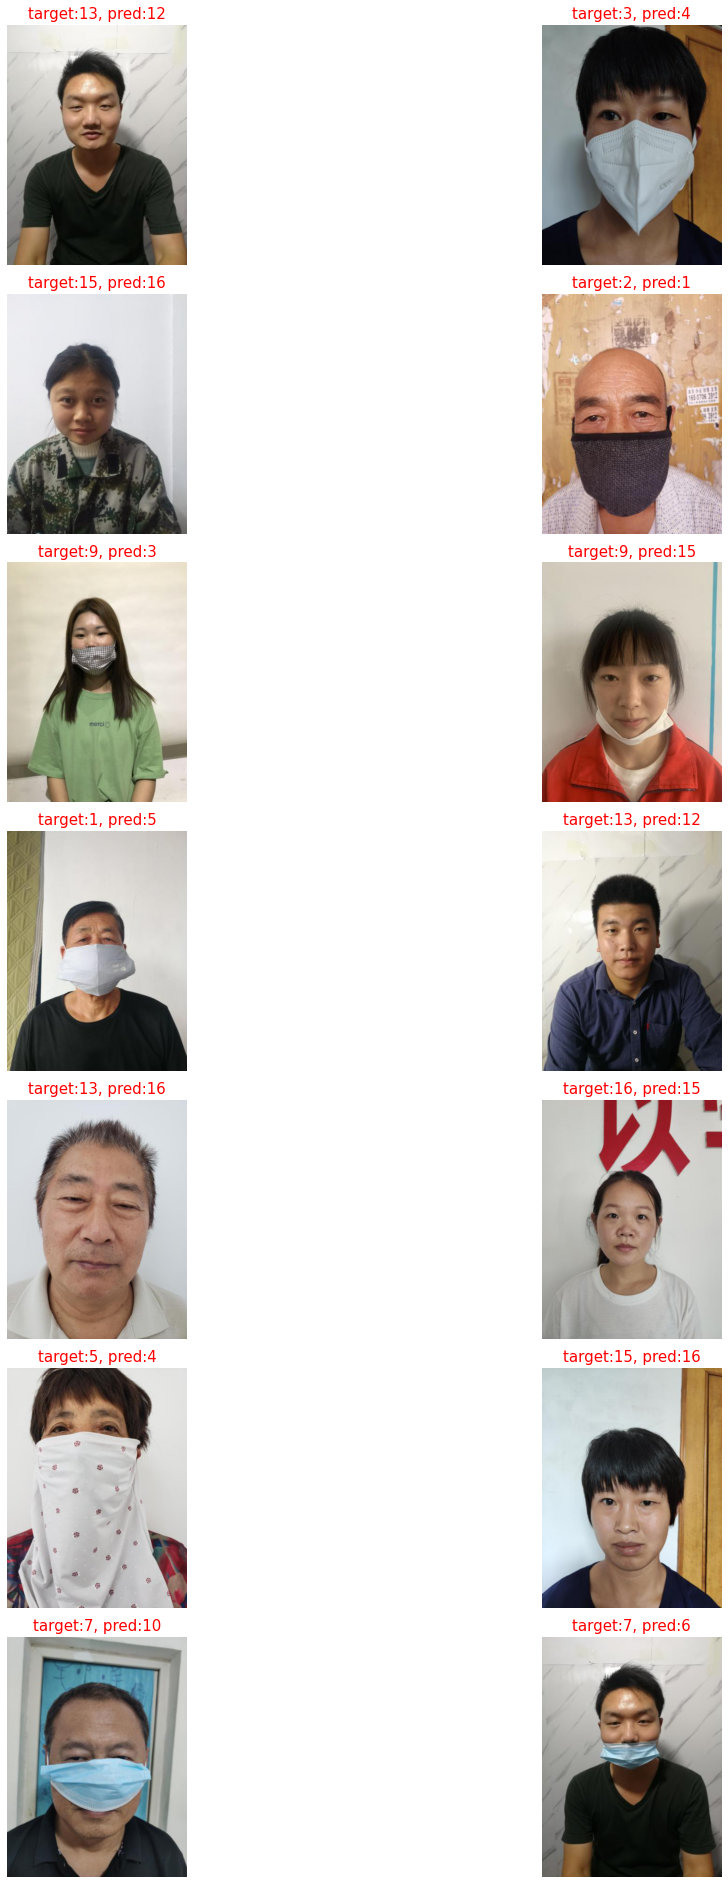

In [31]:
draw_(wrong_df)

### 5.Submit submission file

In [32]:
class TestDataset(Dataset):
    def __init__(self, img_paths, transform):
        self.img_paths = img_paths
        self.transform = transform

    def __getitem__(self, index):
        image = Image.open(self.img_paths[index])

        if self.transform:
            image = self.transform(image)
        return image

    def __len__(self):
        return len(self.img_paths)

In [33]:
# meta 데이터와 이미지 경로를 불러옵니다.
submission = pd.read_csv(os.path.join(test_dir, 'info.csv'))
image_dir = os.path.join(test_dir, 'images')

In [34]:
# Test Dataset 클래스 객체를 생성하고 DataLoader를 만듭니다.
image_paths = [os.path.join(image_dir, img_id) for img_id in submission.ImageID]

transform = transforms.Compose([
    Resize((512, 384), Image.BILINEAR),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.2, 0.2, 0.2)),
])

test_dataset = TestDataset(image_paths, transform)

test_dataloader = DataLoader(test_dataset,
                            shuffle = False)

In [35]:
# 모델이 테스트 데이터셋을 예측하고 결과를 저장합니다.

def test(test_dataloader, model, device):
    all_predictions = []
    model.eval()
    
    for images in test_dataloader:
        with torch.no_grad():
            images = images.to(device)
            pred = model(images)
            pred = pred.argmax(dim=-1)
            all_predictions.extend(pred.cpu().numpy())
    submission['ans'] = all_predictions

    return submission

In [36]:
# 제출할 파일을 저장합니다.

submission = test(test_dataloader, model, device)

submission.to_csv(os.path.join(test_dir, 'submission.csv'), index=False)
print('test inference is done!')

test inference is done!
